IMPORTING LIBRARIES

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,classification_report
from PIL import Image, ImageChops, ImageEnhance
from keras.preprocessing.image import ImageDataGenerator

FUNCTION FOR ELA CONVERSION

In [40]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ela_filename = filename.split('.')[0] + '.ela.png'

    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)

    ela_im = ImageChops.difference(im, resaved_im)

    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    ela_im.save(ela_filename)

    os.remove(resaved_filename)
    return ela_filename

PROVIDING PATH TO DATASET

In [42]:
data_dir = r'D:\\myenv\\NewFakeRealdataset'

LOADING AND PREPROCESSING IMAGES

In [43]:
X = []
Y = []
temp_ela_paths = []

for entry in os.scandir(data_dir):
    for image in os.scandir(entry.path):
        img = cv2.imread(image.path)
        ela_img_path = convert_to_ela_image(image.path, 90)
        temp_ela_paths.append(ela_img_path)

        ela_img = Image.open(ela_img_path).resize((128, 128))
    
        X.append(np.array(ela_img) / 255.0)
    
        label = 1 if 'f' in entry.name[0] else 0
        Y.append(label)

for ela_img_path in temp_ela_paths:
    try:
        os.remove(ela_img_path)
    except FileNotFoundError:
        pass


In [44]:
X = np.array(X)
Y = np.array(Y)

SPLITTING DATASET INTO TRAINING, VALIDATION AND TEST DATASET

In [45]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.3, shuffle=True, stratify=Y, random_state=123)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5, shuffle=True, stratify=Y_val_test, random_state=123)

DATA AUGMENTATION

In [46]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [47]:
train_datagen = datagen.flow(X_train, Y_train, batch_size=32)
val_datagen = datagen.flow(X_val, Y_val, batch_size=32, shuffle=False)
test_datagen = datagen.flow(X_test, Y_test, batch_size=32, shuffle=False)

In [48]:
print("Total number of images:", len(X))
print("Number of training images:", len(X_train))
print("Number of validation images:", len(X_val))
print("Number of test images:", len(X_test))

Total number of images: 3010
Number of training images: 2107
Number of validation images: 451
Number of test images: 452


DEFINING MODEL ARCHITECTURE

In [49]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D((4, 4)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((3, 3)),
    Dropout(0.3),  # for regularization

    Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

COMPILING THE MODEL 

In [50]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights_now.h5", verbose=1, save_best_only=True)

TRAINING THE MODEL

In [52]:
history = model.fit(train_datagen, 
                    epochs=100,
                    validation_data=val_datagen,
                    callbacks=[early_stopping, checkpointer])

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5259
Epoch 1: val_loss improved from inf to 0.69043, saving model to fakevsreal_weights_now.h5
66/66 [==============================] - 14s 175ms/step - loss: 0.6931 - accuracy: 0.5259 - val_loss: 0.6904 - val_accuracy: 0.5388
Epoch 2/100


C:\Users\ANSHIKA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.5420
Epoch 2: val_loss improved from 0.69043 to 0.65848, saving model to fakevsreal_weights_now.h5
66/66 [==============================] - 11s 168ms/step - loss: 0.6898 - accuracy: 0.5420 - val_loss: 0.6585 - val_accuracy: 0.6164
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.5980
Epoch 3: val_loss did not improve from 0.65848
66/66 [==============================] - 11s 164ms/step - loss: 0.6763 - accuracy: 0.5980 - val_loss: 0.6830 - val_accuracy: 0.5632
Epoch 4/100
66/66 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.6588
Epoch 4: val_loss improved from 0.65848 to 0.64018, saving model to fakevsreal_weights_now.h5
66/66 [==============================] - 11s 167ms/step - loss: 0.6227 - accuracy: 0.6588 - val_loss: 0.6402 - val_accuracy: 0.6452
Epoch 5/100
66/66 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.6811
E

SAVING THE MODEL

In [53]:
model.save('fakevsreal_model_now.h5')

EVALUATING THE MODEL

In [54]:
validation_loss, validation_accuracy = model.evaluate(val_datagen)

print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Validation Loss: {validation_loss}")

#Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_datagen, verbose=2)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

15/15 [==============================] - 2s 100ms/step - loss: 0.3204 - accuracy: 0.8603
Validation Accuracy: 86.03%
Validation Loss: 0.3203950822353363
15/15 - 2s - loss: 0.2662 - accuracy: 0.8783 - 2s/epoch - 112ms/step
Test Loss: 0.2662
Test Accuracy: 87.83%


PLOTTING LOSS AND ACCURACY GRAPH

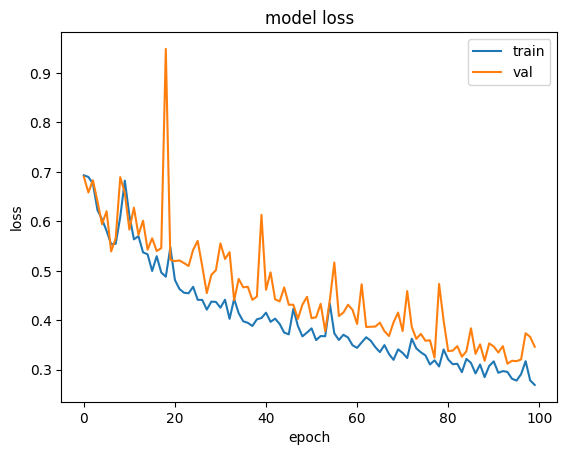

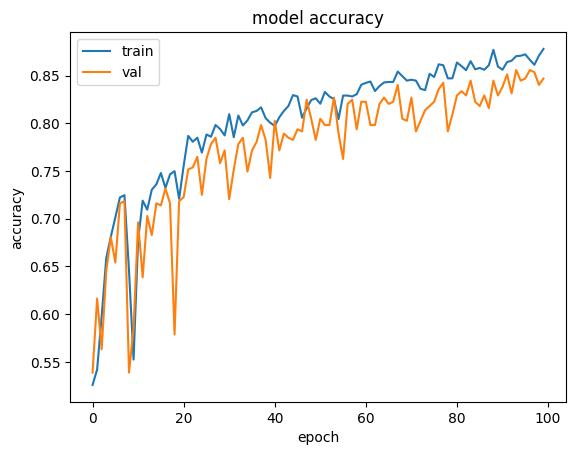

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

LOADING MODEL FOR PREDICTION

In [56]:
model_json = model.to_json()
with open("fakevsreal_model_now.json", "w") as json_file:
    json_file.write(model_json)

# Load the model for predictions
with open('fakevsreal_model_now.json', 'r') as json_file:
    json_savedModel = json_file.read()

# Load the model weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('fakevsreal_weights_now.h5')
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

MAKING PREDICTIONS ON TEST SET

15/15 [==============================] - 1s 68ms/step
Accuracy: 87.83%
F1 Score: 0.88
Precision: 0.89
Recall: 0.88


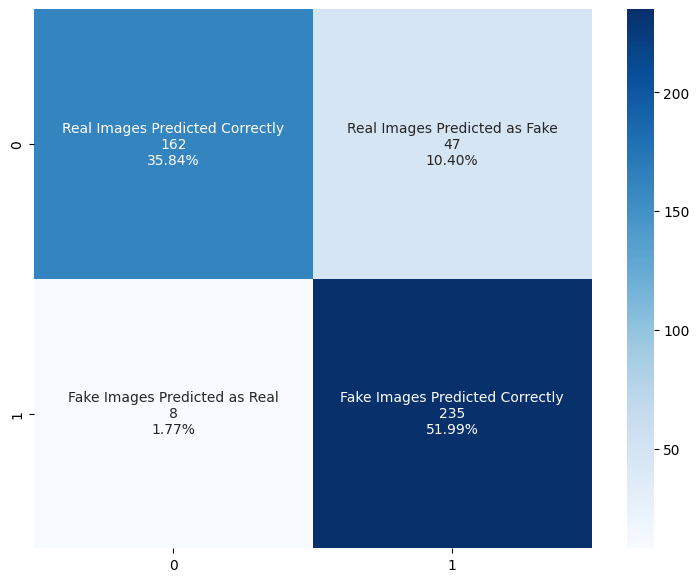

              precision    recall  f1-score   support

           0       0.95      0.78      0.85       209
           1       0.83      0.97      0.90       243

    accuracy                           0.88       452
   macro avg       0.89      0.87      0.88       452
weighted avg       0.89      0.88      0.88       452



In [59]:
predictions = model.predict(test_datagen)

predict = []
for i in predictions:
    predict.append(np.argmax(i))

predict = np.asarray(predict)

accuracy = accuracy_score(Y_test, predict)
f1=f1_score(Y_test,predict,average='weighted')
precision=precision_score(Y_test,predict,average='weighted')
recall=recall_score(Y_test,predict,average='weighted')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

# plot the confusion matrix

cf_matrix = confusion_matrix(Y_test, predict)
plt.figure(figsize=(9, 7))

group_names = ['Real Images Predicted Correctly', 'Real Images Predicted as Fake', 'Fake Images Predicted as Real',
               'Fake Images Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()

report = classification_report(Y_test, predict)
print(report)